In [1]:
import os, sys
currentdir = os.path.dirname(os.getcwd())
sys.path.append(currentdir)

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import math
import os
from utils import models_new
from utils import callbacks
from utils import losses


In [4]:
import importlib
importlib.reload(callbacks)

<module 'utils.callbacks' from '/home/sandra/Documents/PHD_projects/Cycle_gan/utils/callbacks.py'>

In [2]:
# Model / data parameters
from utils.preprocessing import prepare_dataset

ROOT_DIR = '/mnt/Archive/Data_Sets/MesoThermo'

# Directories
dir_fasta = os.path.join(ROOT_DIR,'FASTA')
dir_blast = os.path.join(ROOT_DIR,'BLAST_record')
dir_pdb = '/mnt/Archive/PDB'
outfolder = os.path.join(ROOT_DIR,'Dist_Mat/Thermophile')

name_thermo = 'dist_termo.fasta'
name_meso   = 'dist_meso.fasta'

dir_ = '/mnt/Archive/Data_Sets/OGT/ogt_classes'
name_thermo = 'ogt_70_81.fasta'
name_meso = 'ogt_4_15.fasta'

thermo_train, thermo_val, n_thermo_train, n_thermo_val = prepare_dataset(dir_, name_thermo, file_format = 'fasta', seq_length = 512, max_samples = 10000)
meso_train,   meso_val, n_meso_train, n_meso_val   = prepare_dataset(dir_, name_meso  , file_format = 'fasta', seq_length = 512, max_samples = 10000)


In [3]:
# Synthetic data

# Generate Data with "bi-grams difference"
residues = [0, 1, 2, 3, 4]
data_A = np.random.choice(residues, size = (10000,100), p=[2/5, 1/5, 1/5, 1/10, 1/10])
data_B = np.random.choice(residues, size = (10000,100), p=[1/10, 1/10, 1/5, 1/5, 2/5])


import tensorflow as tf
import utils.preprocessing as pre
bin_seqs_A = np.array([pre.synt2binary(data_A[i,:]) for i in range(10000)])
bin_seqs_B = np.array([pre.synt2binary(data_B[i,:]) for i in range(10000)])
W_A = np.ones_like(data_A)
thermo_train = tf.data.Dataset.from_tensor_slices((data_A, bin_seqs_A, W_A))
meso_train = tf.data.Dataset.from_tensor_slices((data_B, bin_seqs_B, W_A))

KeyboardInterrupt: 

In [19]:
import importlib
importlib.reload(callbacks)

<module 'utils.callbacks' from '/home/sandra/Documents/PHD_projects/Cycle_gan/utils/callbacks.py'>

In [8]:
# Callbacs

pcaobj = callbacks.PCAPlot(thermo_train, meso_train, logdir='log/img') 

#kldiv = callbacks.KLMonitor(data_A, data_B, residues)

In [21]:
pcaobj(thermo_val, meso_val, 7)

833
781


In [14]:
print(pcaobj.features_thermo[0])
print(pcaobj.features_meso[0])

[0.09633028 0.         0.08256881 0.06192661 0.01834862 0.08715596
 0.0206422  0.08486239 0.07339449 0.09174312 0.03669725 0.04357798
 0.02293578 0.02752294 0.02752294 0.05504587 0.06651376 0.08715596
 0.         0.01605505]
[0.0483871  0.         0.0483871  0.08064516 0.0483871  0.08064516
 0.         0.0483871  0.03225806 0.03225806 0.         0.06451613
 0.03225806 0.06451613 0.08064516 0.06451613 0.0483871  0.16129032
 0.01612903 0.0483871 ]


In [3]:
import matplotlib.pyplot as plt

features_gen_thermo = pcaobj.calc_freq(thermo_val)
features_gen_meso   = pcaobj.calc_freq(meso_val)

pc_gen_thermo = pcaobj.pca.transform(features_gen_thermo)
pc_gen_meso   = pcaobj.pca.transform(features_gen_meso)

X_pca = np.concatenate((pcaobj.pc_thermo, pcaobj.pc_meso, pc_gen_thermo, pc_gen_meso))
        
idx_thermo     = pcaobj.pc_thermo.shape[0]
idx_meso       = idx_thermo + pcaobj.pc_meso.shape[0]
idx_gen_thermo = idx_meso + pc_gen_thermo.shape[0]
idx_gen_meso   = idx_gen_thermo + pc_gen_meso.shape[0]
# color classes
y = np.ones((idx_gen_meso,))
y[idx_thermo:idx_meso] = 2
y[idx_meso:idx_gen_thermo] = 3
y[idx_gen_thermo:idx_gen_meso] = 4

fig = plt.figure(figsize=(15,15))

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s = 10, cmap ='jet')

plt.title('PCA plot of {}-gram frequency'.format('word_length'))
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend2 = plt.legend(handles, ['Thermophiles', 'Mesophiles'], loc="upper right", title="Distributions")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

NameError: name 'pcaobj' is not defined

In [4]:
kldiv.dist_b

array([0.100126, 0.099798, 0.199633, 0.200523, 0.39992 ], dtype=float32)

In [3]:
# Create model

model_type = 'res'

G_filters = [64, 64, 128, 128, 256, 256]
G_sizes   = [3, 3, 3, 3, 3, 3]
G_dilation= [1, 1, 1, 1, 1, 1]


D_filters = [64, 64, 128, 128, 256, 256]
D_sizes   = [3, 3, 3, 3, 3, 3]
D_dilation= [1, 1, 1, 1, 1, 1]
D_strides = [1, 1, 2, 2, 2, 2]
vocab = 21



G = models_new.Generator_res(G_filters, G_sizes, G_dilation, vocab)
F = models_new.Generator_res(G_filters, G_sizes, G_dilation, vocab)
D_x  = models_new.Discriminator(D_filters, D_sizes, D_strides, D_dilation, vocab)
D_y  = models_new.Discriminator(D_filters, D_sizes, D_strides, D_dilation, vocab)

In [4]:
#cycle gan

class MyModel(tf.keras.Model):

    def __init__(self,model_encode, model_decode, model_discrim_x, model_discrim_y, lambda_cycle = 10):
        super(MyModel, self).__init__()
        self.G = model_encode
        self.F = model_decode
        self.D_x = model_discrim_x
        self.D_y = model_discrim_y
        self.lambda_cycle = lambda_cycle
        self.nois = tf.keras.layers.GaussianNoise(0.2)
        self.add  = tf.keras.layers.Add()
        


    def call(self, batch_data, training = True):
        _, X_bin, W_x = batch_data[0]
        _, Y_bin, W_y= batch_data[1]
        
        fake_y, _ = self.G(X_bin, training=training)
        fake_x, _ = self.F(Y_bin, training=training)
        
        # Identity mapping
        same_x, _ = self.F(X_bin, training=True)
        same_y, _ = self.G(Y_bin, training=True)
        
        # Cycle: x -> y -> x
        cycled_x, _ = self.F(fake_y, training=training)
        cycled_y, _ = self.G(fake_x, training=training)

        # Discriminator output
        #Y_bin = tf.keras.activations.softmax(self.nois(Y_bin)) 
        disc_real_y, _ = self.D_y(Y_bin, training=training)
        disc_fake_y, _ = self.D_y(fake_y, training=training)
        disc_real_x, _ = self.D_x(X_bin, training=training)
        disc_fake_x, _ = self.D_x(fake_x, training=training)
        
        return cycled_x, cycled_y, same_x, same_y, disc_real_x, disc_fake_x, disc_real_y, disc_fake_y, ((fake_y, fake_x),(cycled_x, cycled_y))

@tf.function
def train_step(model, batch_data, loss_obj, optimizers,lambda_cycle = 1, lambda_id = 0.5):
    
    #generator_loss_fn = loss_fns.generator_loss_fn
    #cycle_loss_fn = loss_fns.cycle_loss_fn
    #disc_loss_fn = loss_fns.discriminator_loss_fn
    
    G_optimizer = optimizers[0]
    F_optimizer = optimizers[1]
    Dx_optimizer = optimizers[2]
    Dy_optimizer = optimizers[3]
    
    _, X_bin, W_x= batch_data[0]
    _, Y_bin, W_y= batch_data[1]

    
    with tf.GradientTape(persistent=True) as tape:
        cycled_x, cycled_y, same_x, same_y, disc_real_x, disc_fake_x, disc_real_y, disc_fake_y, logits = model(batch_data)


        
        gen_G_loss = loss_obj.generator_loss_fn(disc_fake_y)
        gen_F_loss = loss_obj.generator_loss_fn(disc_fake_x)
        
        id_G_loss = loss_obj.cycle_loss_fn(Y_bin, same_y, W_y) 
        id_F_loss = loss_obj.cycle_loss_fn(X_bin, same_x, W_x) 
        
        gen_cycle_x_loss = loss_obj.cycle_loss_fn(X_bin, cycled_x, W_x) 
        gen_cycle_y_loss = loss_obj.cycle_loss_fn(Y_bin, cycled_y, W_y)
        
        
        
        # Discriminator loss
        tot_loss_G = gen_G_loss + gen_cycle_x_loss * lambda_cycle + id_G_loss * lambda_cycle * lambda_id
        tot_loss_F = gen_F_loss + gen_cycle_y_loss * lambda_cycle + id_F_loss * lambda_cycle * lambda_id
    
        loss_D_y = loss_obj.discriminator_loss_fn(disc_real_y, disc_fake_y)
        loss_D_x = loss_obj.discriminator_loss_fn(disc_real_x, disc_fake_x)
    
    grads_G = tape.gradient(tot_loss_G, model.G.trainable_variables)

    grads_F = tape.gradient(tot_loss_F, model.F.trainable_variables)
    
    # Get the gradients for the discriminators
    grads_disc_y = tape.gradient(loss_D_y, model.D_y.trainable_variables)
    grads_disc_x = tape.gradient(loss_D_x, model.D_x.trainable_variables)
    
    # Update the weights of the generators 
    G_optimizer.apply_gradients(zip(grads_G, model.G.trainable_variables))  
    F_optimizer.apply_gradients(zip(grads_F, model.F.trainable_variables))

    # Update the weights of the discriminators
    Dy_optimizer.apply_gradients(zip(grads_disc_y, model.D_y.trainable_variables))
    Dx_optimizer.apply_gradients(zip(grads_disc_x, model.D_x.trainable_variables))

    return {
        "Gen_G_loss": gen_G_loss,
        "Cycle_X_loss": gen_cycle_x_loss,
        "Disc_X_loss": loss_D_x,
        "Gen_F_loss": gen_F_loss,
        "Cycle_Y_loss": gen_cycle_y_loss,
        "Disc_Y_loss": loss_D_y
    }, logits




In [5]:
#!rm -rf ./log/

In [7]:
# Training

# Create cycle gan model
cycle_gan_model = MyModel(G,F, D_x, D_y, lambda_cycle=10)

loss_obj = losses.HingeLoss()

# Callbacks

train_loss_G       = tf.keras.metrics.Mean('loss_G', dtype=tf.float32)
train_loss_cycle_x = tf.keras.metrics.Mean('loss_cycle_x', dtype=tf.float32)
train_loss_disc_y  = tf.keras.metrics.Mean('loss_disc_y', dtype=tf.float32)
train_loss_F       = tf.keras.metrics.Mean('loss_F', dtype=tf.float32)
train_loss_cycle_y = tf.keras.metrics.Mean('loss_cycle_y', dtype=tf.float32)
train_loss_disc_x  = tf.keras.metrics.Mean('loss_disc_x', dtype=tf.float32)

temp_diff_x  = tf.keras.metrics.Mean('temp_diff_x', dtype=tf.float32)
temp_diff_y  = tf.keras.metrics.Mean('temp_diff_y', dtype=tf.float32)

train_acc_x       = tf.keras.metrics.CategoricalAccuracy()
train_cycled_acc_x = tf.keras.metrics.CategoricalAccuracy()
train_acc_y       = tf.keras.metrics.CategoricalAccuracy()
train_cycled_acc_y = tf.keras.metrics.CategoricalAccuracy()

# Optimizers
G_opt=keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5)
F_opt=keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5)
Dx_opt=keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5)
Dy_opt=keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.5)

#file writer

base_dir = 'log/exp_all3'
G_summary_writer = tf.summary.create_file_writer(os.path.join(base_dir,'G'))
F_summary_writer = tf.summary.create_file_writer(os.path.join(base_dir,'F'))

D_x_summary_writer = tf.summary.create_file_writer(os.path.join(base_dir,'D_x'))
D_y_summary_writer = tf.summary.create_file_writer(os.path.join(base_dir,'D_y'))

X_c_summary_writer = tf.summary.create_file_writer(os.path.join(base_dir,'X_c'))
Y_c_summary_writer = tf.summary.create_file_writer(os.path.join(base_dir,'Y_c'))

temp_diff_summary_x = tf.summary.create_file_writer(os.path.join(base_dir,'temp_diff_x'))
temp_diff_summary_y = tf.summary.create_file_writer(os.path.join(base_dir,'temp_diff_y'))


pcaobj = callbacks.PCAPlot(thermo_train.as_numpy_iterator(), meso_train.as_numpy_iterator(), n_thermo_train, n_meso_train, logdir=os.path.join(base_dir,'img')) 

filters = [64, 64, 64, 128, 128, 128, 256, 256, 256]
sizes   = [6, 6, 6, 6, 6, 6, 4, 4, 4]
dilation= [1, 1, 1, 1, 1, 1, 1, 1, 1]
strides = [1, 2, 2, 1, 2, 2, 1, 1, 2]
vocab = 21
reg_model = models_new.Classifier(filters, sizes, strides, dilation, vocab)
reg_model.load_weights('../weights/model_ogt')

# Training
for i in range(400):
    batches_x = meso_train.shuffle(buffer_size = 40000).batch(32, drop_remainder=True) 
    batches_y = thermo_train.shuffle(buffer_size = 40000).batch(32, drop_remainder=True)
    for step, x in enumerate(zip(batches_x,batches_y)):
    
        losses_, logits = train_step(model = cycle_gan_model, batch_data = x,
                            loss_obj = loss_obj,
                            optimizers = [G_opt, F_opt, Dx_opt, Dy_opt],
                           lambda_cycle = 10,
                            lambda_id = 0.2)

        train_loss_G(losses_["Gen_G_loss"]) 
        train_loss_cycle_x(losses_["Cycle_X_loss"])
        train_loss_disc_y(losses_["Disc_X_loss"])
        train_loss_F(losses_["Gen_F_loss"]) 
        train_loss_cycle_y(losses_["Cycle_Y_loss"])
        train_loss_disc_x(losses_["Disc_Y_loss"])
        
        train_acc_x(x[0][1], logits[0][0], x[0][2])
        train_acc_y(x[1][1], logits[0][1], x[1][2])
        train_cycled_acc_x(x[0][1], logits[1][0], x[0][2])
        train_cycled_acc_y(x[1][1], logits[1][1], x[1][2])
        
    
    if i % 2 == 0:
        
        # PCA clustering to measure diversity
        val_x = thermo_val.shuffle(buffer_size = 40000).batch(1, drop_remainder=False)
        val_y = meso_val.shuffle(buffer_size = 40000).batch(1, drop_remainder=False)
        
        W_y = np.zeros((n_meso_val,512)) #TODO
        W_x = np.zeros((n_thermo_val,512)) #TODO
        gen_y = np.zeros((n_thermo_val,512))
        gen_x = np.zeros((n_meso_val,512))
        
        
        for k, item in enumerate(val_x):
            _, X_bin, w_x = item    
            logits, _ = cycle_gan_model.G(X_bin)
            tmp = tf.math.argmax(logits, axis = 2).numpy()
            gen_y[k,:] = tmp    
            W_x[k,:] = w_x.numpy()
        
        
        for k, item in enumerate(val_y):
            _, Y_bin, w_y = item    
            logits, _ = cycle_gan_model.F(Y_bin)
            tmp = tf.math.argmax(logits, axis = 2).numpy()
            gen_x[k,:] = tmp
            W_y[k,:] = w_y.numpy()
        
        
        df_gen_y = zip(list(gen_y), list(W_x), list(W_x))
        df_gen_x = zip(list(gen_x), list(W_y), list(W_y)) 
        
        pcaobj(df_gen_y, df_gen_x, n_thermo_val, n_meso_val, step=i)
        
        # Get temp dif
        for k, item in enumerate(batches_x):
            _, X_bin, W_x = item 
            logit, _ = cycle_gan_model.G(X_bin)
            W_x = tf.reshape(W_x, shape=(32,512,1))
            W_x = tf.repeat(W_x, repeats=21, axis=2)
            trans_x = tf.math.multiply(W_x, logit)
            logits_real  = reg_model(X_bin)
            logits_trans = reg_model(trans_x)
            diff = tf.math.reduce_mean(tf.math.subtract(logits_trans,logits_real))
            temp_diff_x(diff)
        for k, item in enumerate(batches_y):
            _, Y_bin, W_y = item 
            logit, _ = cycle_gan_model.F(Y_bin)
            W_y = tf.reshape(W_y, shape=(32,512,1))
            W_y = tf.repeat(W_y, repeats=21, axis=2)
            trans_y = tf.math.multiply(W_y, logit)
            logits_real  = reg_model(Y_bin)
            logits_trans = reg_model(trans_y)
            diff = tf.math.reduce_mean(tf.math.subtract(logits_trans,logits_real))
            temp_diff_y(diff)
        
        with temp_diff_summary_x.as_default():
            tf.summary.scalar('temp_diff', temp_diff_x.result(), step=i, description = 'temp_diff_x')
        with temp_diff_summary_y.as_default():
            tf.summary.scalar('temp_diff', temp_diff_y.result(), step=i, description = 'temp_diff_y')
        temp_diff_x.reset_states()
        temp_diff_y.reset_states()
           
        
    print("Epoch: %d Loss_G: %2.4f Loss_F: %2.4f Loss_cycle_X: %2.4f Loss_cycle_Y: %2.4f Loss_D_Y: %2.4f Loss_D_X %2.4f" % 
          (i, float(train_loss_G.result()), float(train_loss_F.result()), float(train_loss_cycle_x.result()), float(train_loss_cycle_y.result()), float(train_loss_disc_y.result()), float(train_loss_disc_x.result())))
    print("Epoch: %d acc trans x: %2.4f acc trans y: %2.4f acc cycled x : %2.4f acc cycled y: %2.4f" % 
          (i, train_acc_x.result(), train_acc_y.result(), train_cycled_acc_x.result(), train_cycled_acc_y.result()))
    
    
    with G_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss_G.result(), step = i, description = 'X transform')
            tf.summary.scalar('acc', train_acc_x.result(), step = i, description = 'X transform' )
            
            
    with F_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss_F.result(), step = i, description = 'Y transform')
        tf.summary.scalar('acc', train_acc_y.result(), step = i, description = 'Y transform' )
                  
    with D_x_summary_writer.as_default():         
        tf.summary.scalar('loss', train_loss_disc_y.result(), step = i, description = 'X discriminator')        
    with D_y_summary_writer.as_default():        
        tf.summary.scalar('loss', train_loss_disc_x.result(), step = i, description = 'Y discriminator')    
    with X_c_summary_writer.as_default(): 
        tf.summary.scalar('loss', train_loss_cycle_x.result(), step = i, description = 'X cycle')
        tf.summary.scalar('acc', train_cycled_acc_x.result(), step = i, description = 'X cycle' )         
    with Y_c_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss_cycle_y.result(), step = i, description = 'Y cycle')
        tf.summary.scalar('acc', train_cycled_acc_y.result(), step = i, description = 'Y cycle' )
        
    
    
    train_loss_G.reset_states()
    train_loss_cycle_x.reset_states()
    train_loss_disc_y.reset_states()
    train_loss_F.reset_states() 
    train_loss_cycle_y.reset_states()
    train_loss_disc_x.reset_states()
    
    train_acc_x.reset_states()
    train_acc_y.reset_states()
    train_cycled_acc_x.reset_states()
    train_cycled_acc_y.reset_states()

ValueError: Shapes (256,) and (100,) are incompatible

In [9]:
print(set(data_gen_y))

set()


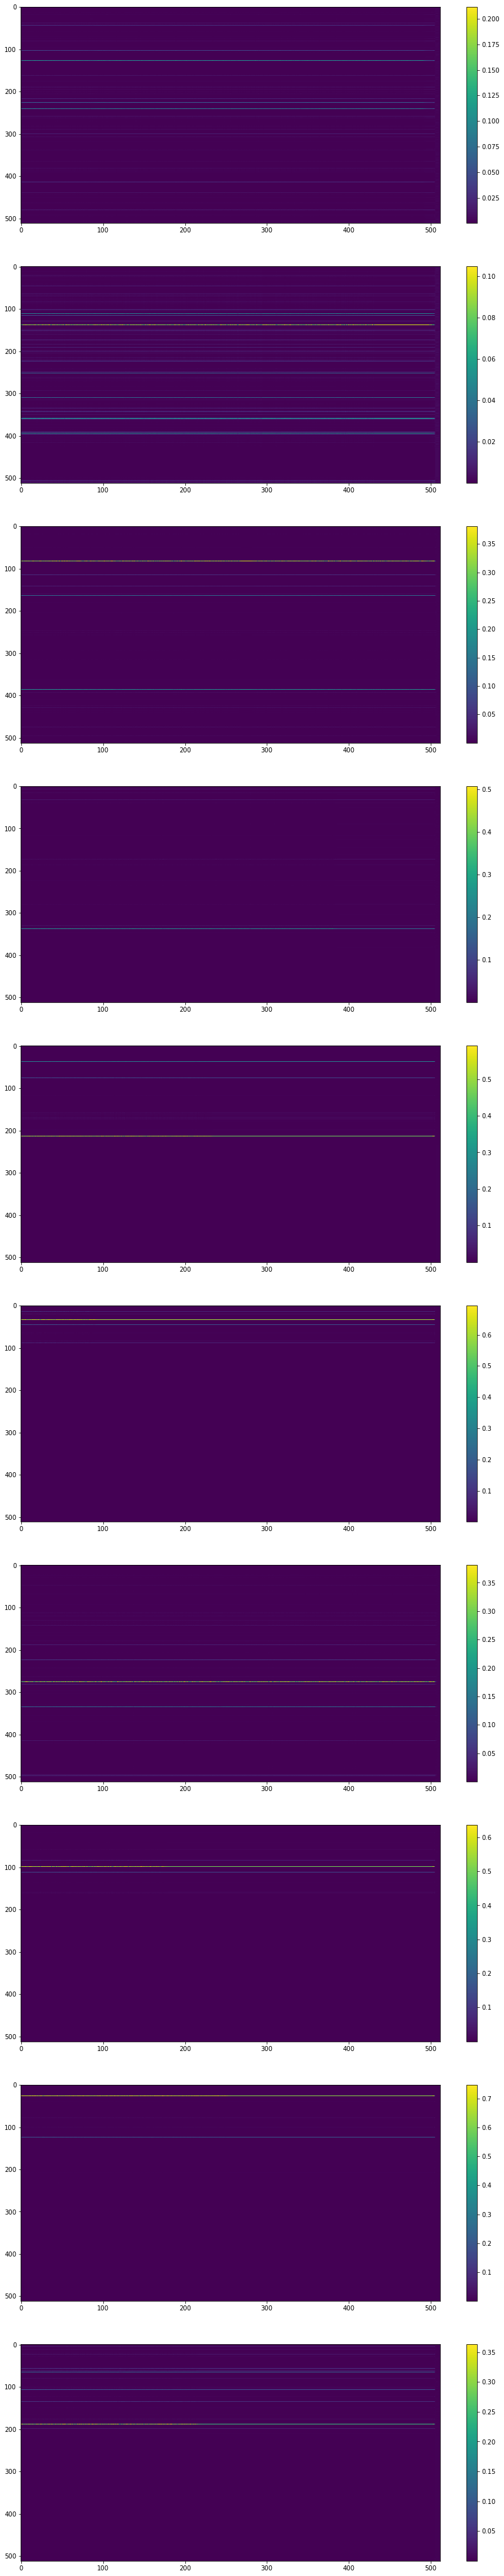

In [8]:
import matplotlib.pyplot as plt
tf.keras.layers.GlobalAveragePooling1D()

batches_m = meso_train.batch(128, drop_remainder=True)
batches_z = thermo_train.batch(128, drop_remainder=True)
for i, seq in enumerate(zip(batches_m, batches_z)):
    if i > 1:
        break
    X_int, X_bin, W_x = seq[0]
    Z_int, Z_bin, W_z = seq[1]
    y_fake, a_G = cycle_gan_model.G(X_bin)
    y, a_D = cycle_gan_model.D_x(y_fake)

fig, axs  = plt.subplots(10,1)#sharex = True, gridspec_kw = {'height_ratios': [1,8]})
fig.set_figheight(75)
fig.set_figwidth(15)
for i in range(10):
    im =axs[i].imshow(a_G.numpy()[i,:,:], aspect="auto")
    axs[i].figure.colorbar(im, ax=axs[i])

    
plt.show()

In [7]:
cycle_gan_model.D_x.atte.gamma

<tf.Variable 'gamma:0' shape=() dtype=float32, numpy=3.2451434>

In [27]:
d ={0: 'A',
        1: 'C',
        2: 'D',
        3: 'E',
        4: 'F',
        5: 'G',
        6: 'H',
        7: 'I',
        8: 'K',
        9: 'L',
        10: 'M',
        11: 'N',
        12: 'P',
        13: 'Q',
        14: 'R',
        15: 'S',
        16: 'T',
        17: 'V',
        18: 'W',
        19: 'Y',
        20: 'X',}

seqs_c = []
seqs_x = []
seqs_y = []
seqs_t = []
batches = meso_train.batch(128, drop_remainder=True)
for i, seq in enumerate(batches):
    if i > 1:
        break
    X_int, X_bin, W_x = seq
    prediction, _ = cycle_gan_model.G(X_bin)
    prediction_t = tf.keras.backend.argmax(prediction, axis=-1)
    prediction_c, _ = cycle_gan_model.F(prediction)
    prediction_c = tf.keras.backend.argmax(prediction_c, axis=-1)
    for j in range(128):
        stop = int(tf.reduce_sum(W_x[j], axis=None).numpy())
        seqs_t.append((''.join([d[i] for i in prediction_t[j].numpy()[:stop]]), str(i)+'_changed'))
        seqs_x.append((''.join([d[i] for i in X_int[j].numpy()[:stop]]), str(i)+'_Meso'))
        seqs_c.append((''.join([d[i] for i in prediction_c[j].numpy()[:stop]]), str(i)+'_cyceld'))
batches = thermo_train.batch(128, drop_remainder=True)
for i, seq in enumerate(batches):
    
    X_int, X_bin, W_x = seq
    for j in range(128):       
        seqs_y.append((''.join([d[i] for i in X_int[j].numpy()[:stop]]), str(j)+'_Thermo'))


In [26]:
print(stop.numpy())
print(prediction_t[j].numpy()[1])#[:stop])

62.0
13


In [28]:
print(seqs_y[1])

('NELLHLAPNVWPRNTTRDEVGVVCIAGIPLTQLAQEYGTPLFVIDEDDFRSRCRETAAAFGSGANVHYAAKAFLCSEVARWISEEGLCLDVCTGGELAVALHASFPPERITLHG', '1_Thermo')


In [32]:
print(seqs_x[1])

('NQYDNDVTVWSPQGRIHQIEYAMEAVKQGSATVGLKSKTHAVLVALKRAQSELAAHQKKILHVDNHIGISIAGLTADARLLCNFMRQECLDSRFVFDRPLPVSRLVSLIGSKTQIPTQRYGRRPYGVGLLIAGYDDMGPHIFQTCPSANYFDCRAMSIGARSQSARTYLERHMSEFMECNLNELVKHGLRALRETLPAEQDLTTKNVSIGIVGKDLEFTIYDDDDVSPFLEGLEERPQ', '0_Meso')


In [33]:
print(seqs_t[1])

('NQYDNDVTVVSPQGRIHQIEYAMEAVKQGSATVGLKSKTHAVLVAEKRAQSEVAAVQKKILHVDNHIGISIAGETAVARLLANFMRQEVLDSRFVFDRPLPVSRLVSLIGSKTQIPTQRYGRRPYGVGLLIAGYDDMGPHIFQTSPSANYFDSRAMSIGARSQSARTYVERVMSEFMEANLNELVKHGLRALRETLPAEQDETTKNVSIGIVGKDVEFTIYDDDDVSPFVEGLEERPQ', '0_changed')


In [31]:
print(seqs_c[3])

('GTFTWTLSDSEGKDTPGGYCLTRWMLIEAELKCFGNTAVAKCNEKHDEEFCDMLRLFDFNKQAIQRLKAXXQTSIQLINKAVNALINDQLIMKNHLRDIMCIPYCNYSKYWYLNHTTTGRTSLPKCWLVSNGSYLNETHFSDDIEQQADNMITEMLQ', '0_cyceld')


In [ ]:
#Write FASTA

from Bio import SeqIO


name = 'seqs.ali'
with open(name, "w") as output_handle:
        for seq in seqs_c[:100]:
              output_handle.write('>' +seq[1]+'\n'+seq[0]+'\n')
        for seq in seqs_x[:100]:
              output_handle.write('>' +seq[1]+'\n'+seq[0]+'\n')
        for seq in seqs_y[:100]:
              output_handle.write('>' +seq[1]+'\n'+seq[0]+'\n')